In [42]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [43]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop featues with high null column
    df.drop(columns=['floor','expenses'], inplace=True)
    
    # Drop high and low cardinality categorical variables
    df.drop(columns=['operation','property_type','currency','properati_url'], inplace=True)

    # Drop leacky columns
    df.drop(columns=
        ['price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2']
    ,inplace=True)
    
    # Drop columns for multicolinearlity ()
    df.drop(columns=[
        'surface_total_in_m2'
        ,'rooms'
    ], inplace=True)
    return df

In [44]:
# Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. 
# Assign this list to the variable name files.

files=glob('data/buenos-aires-real-estate-*.csv')
files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv']

In [45]:
# Check your work
assert len(files) == 2, f"`files` should contain 5 items, not {len(files)}"

In [46]:
# Use your wrangle function in a list comprehension to create a list named frames. 
# The list should contain the cleaned DataFrames for the filenames your collected in files.
frames=[wrangle(file) for file in files]
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [47]:
# Check your work
assert len(frames) == 2, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

In [49]:
# Use pd.concat to concatenate it items in frames into a single DataFrame df. 
# Make sure you set the ignore_index argument to True.
df = pd.concat(frames)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2658 entries, 4 to 8585
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        2658 non-null   float64
 1   surface_covered_in_m2  2658 non-null   float64
 2   lat                    2561 non-null   float64
 3   lon                    2561 non-null   float64
 4   neighborhood           2658 non-null   object 
dtypes: float64(4), object(1)
memory usage: 124.6+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


<Axes: >

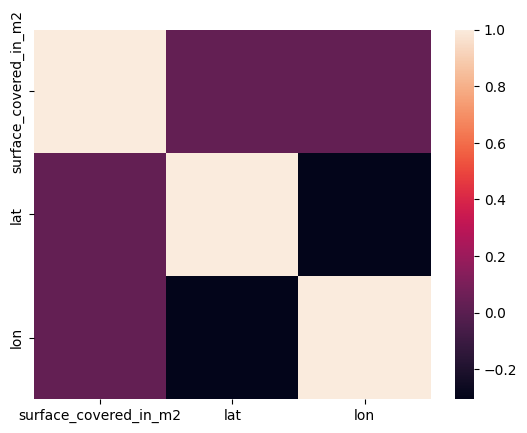

In [50]:
# Plot a correlation heatmap of the remaining numerical features in df. Since "price_aprox_usd" will be your target, 
# you don't need to include it in your heatmap.

corr=df.select_dtypes('number').drop(columns='price_aprox_usd').corr().head()
sns.heatmap(corr)


In [51]:
# Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". 
# Your features should be all the columns that remain in the DataFrame you cleaned above.
target="price_aprox_usd"
features=["surface_covered_in_m2","lat","lon","neighborhood"]
X_train=df[features]
y_train=df[target]


In [52]:
# Calculate the baseline mean absolute error for your model.
y_mean=y_train.mean()
y_pred_baseline=[y_mean] * len(y_train)
base_mae=mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", round(y_mean,2))
print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 134732.97
Baseline MAE: 45422.75166805662


In [53]:
# First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. 
# Next, fit your transformer to the feature matrix X_train. 
# Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train


# instantiate
ohe=OneHotEncoder(use_cat_names=True)
# Fit
ohe.fit(X_train)
# Transform
XT_train=ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(2658, 57)


,surface_covered_in_m2,lat,lon,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,...,neighborhood_Retiro,neighborhood_Versalles,neighborhood_Boca,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati
4,70.0,-34.584651,-58.454693,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,42.0,-34.638979,-58.500115,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,54.0,-34.615847,-58.459957,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,42.0,-34.625222,-58.382382,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,50.0,-34.610610,-58.412511,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Create a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor. 
# Then fit your model to the training data.

model=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [57]:
# Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.
y_pred_training=model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 24638.873983456106


In [69]:
# Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction 
#  for an apartment price.

def make_prediction(area, lat, lon, neighborhood):
    data={
        'surface_covered_in_m2':area,
        'lat':lat, 
        'lon':lon, 
        'neighborhood':neighborhood        
    }
    df=pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)
    return f"Predicted apartment price: ${prediction}"

In [70]:
# Run the cell below to find out!
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[254105.97]'

In [71]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=54, description='area', min=31), FloatSlider(value=-34.598285911342714, …